In [37]:
from numpy import ascontiguousarray as ascont
import numpy as np
from sigmaepsilon.mesh.grid import grid
from sigmaepsilon.mesh import triangulate
from sigmaepsilon.mesh.utils.topology.tr import Q4_to_T3

from sigmaepsilon.solid.material import MindlinPlateSection as Section
from sigmaepsilon.math.linalg import ReferenceFrame
from sigmaepsilon.solid.material import (
    ElasticityTensor,
    LinearElasticMaterial,
    HuberMisesHenckyFailureCriterion_SP,
)
from sigmaepsilon.solid.material.utils import elastic_stiffness_matrix

from sigmaepsilon.solid.fourier import (
    RectangularPlate,
    LoadGroup,
    PointLoad,
    RectangleLoad,
)

size = Lx, Ly = (600.0, 800.0)
E = 2890.0
nu = 0.2
t = 25.0
yield_strength = 25.0
grid_shape = (50, 50)
num_group = 5
max_num_cases_per_group = 2

hooke = elastic_stiffness_matrix(E=E, NU=nu)
frame = ReferenceFrame(dim=3)
stiffness = ElasticityTensor(hooke, frame=frame, tensorial=False)

failure_model = HuberMisesHenckyFailureCriterion_SP(yield_strength=yield_strength)

material = LinearElasticMaterial(stiffness=stiffness, failure_model=failure_model)

section = Section(
    layers=[
        Section.Layer(material=material, thickness=t),
    ]
)
ABDS = section.elastic_stiffness_matrix()
D, S = ascont(ABDS[:3, :3]), ascont(ABDS[3:, 3:])


In [38]:
load_groups = dict()
case_counter, group_counter = 0, 0
for i in range(num_group):
    group_counter += 1
    load_cases = dict()
    number_of_cases = np.random.choice(np.arange(max_num_cases_per_group)+1)
    for j in range(number_of_cases):
        case_counter += 1
        if np.random.rand() > 0.5:
            xA, yA = np.random.rand() * Lx / 2, np.random.rand() * Ly / 2
            xB, yB = xA + np.random.rand() * Lx / 2, yA + np.random.rand() * Ly / 2
            v = np.random.rand(3)
            load_case = RectangleLoad(x=[[xA, yA], [xB, yB]], v=v)
        else:
            load_case = PointLoad(x=[Lx / 3, Ly / 2], v=[-100.0, 0, 0])
        load_cases[f"Case {case_counter}"] = load_case
    cooperative = True if np.random.rand() > 0.8 else False
    load_groups[f"Group {group_counter}"] = LoadGroup(cooperative=cooperative, **load_cases)

loads = LoadGroup(**load_groups)
loads.lock()

print(f"Added {case_counter} cases in {group_counter} groups.")

Added 8 cases in 5 groups.


In [39]:
coords, triangles = Q4_to_T3(*grid(size=size, shape=grid_shape, eshape="Q4"))
triobj = triangulate(points=coords[:, :2], triangles=triangles)[-1]
plate = RectangularPlate(size, (20, 20), D=D, S=S)
loads.problem = plate

In [40]:
import dask
from sigmaepsilon.deepdict import DeepDict

@dask.delayed
def task(group):
    return plate.solve(group, coords)

tasks = [task(group) for group in loads.values()]
results = dask.compute(tasks)[0]
results = DeepDict(**{next(r.keys()):next(r.values()) for r in results})

In [41]:
from itertools import permutations

def get_cooperative_cases(loads):
    groups = filter(lambda b: type(b)==LoadGroup, loads.blocks())
    cooperative_groups = filter(lambda b: b.cooperative, groups)
    for cases in map(lambda g : g.cases(), cooperative_groups):
        for case in cases:
            yield case
            

def get_noncooperative_cases(loads):
    groups = filter(lambda b: type(b)==LoadGroup, loads.blocks())
    noncooperative_groups = filter(lambda b: not b.cooperative, groups)
    for cases in map(lambda g : g.cases(), noncooperative_groups):
        for case in cases:
            yield case


def generate_all_permutations(loads, N):
    cases_coop = [id(obj) for obj in get_cooperative_cases(loads)]
    cases_noncoop = [id(obj) for obj in get_noncooperative_cases(loads)]

    for i in range(0, N+1):
        num_coops = i
        perm_coops = permutations(cases_coop, num_coops) if num_coops > 0 else [()]
        for perm_coop in perm_coops:
            num_noncoops = N-i
            perm_noncoops = permutations(cases_noncoop, num_noncoops) if num_noncoops > 0 else [()]
            for perm_noncoop in perm_noncoops:
                yield perm_coop + perm_noncoop


gen = generate_all_permutations(loads, 5)
for _ in range(5):
    print(next(gen))

(1989319767200, 1989319767360, 1989319766720, 1989319767760, 1989319767920)
(1989319767200, 1989319767360, 1989319766720, 1989319767920, 1989319767760)
(1989319767200, 1989319767360, 1989319767760, 1989319766720, 1989319767920)
(1989319767200, 1989319767360, 1989319767760, 1989319767920, 1989319766720)
(1989319767200, 1989319767360, 1989319767920, 1989319766720, 1989319767760)


## Finding the maximum utilization

In [42]:
factors = [1.35, 1.5, 1.15,] #0.9, 0.5]
cases = {id(obj): obj for obj in loads.cases()}
case_results = {k: results[c.parent.key, c.key] for k, c in cases.items()}

z = np.linspace(-1, 1, 3)
rng = (-1, 1)

### Solution with serial execution

In [43]:
import contextlib
from sigmaepsilon.core.formatting import floatformatter

generator = generate_all_permutations(loads, len(factors))

max_util = -1
critical_combination = None
number_of_combinations = 0

with contextlib.suppress(StopIteration):
    while True:
        number_of_combinations += 1
        combination_members = next(generator)
        combination = zip(factors, combination_members)
        combination_result = sum(
            [f * case_results[case_id] for f, case_id in combination]
        )
        strains = combination_result[:, 3:8]
        util, util_coords = section.utilization(
            strains=strains.values, rng=rng, z=z, coords=coords, return_coords=True
        )
        max_util_combination = util.values.max()
        if max_util_combination > max_util:
            max_util = max_util_combination
            critical_combination = combination_members

formatter = floatformatter(sig=3)
frmt = lambda s: formatter.format(s)
factor_strings = [frmt(f) for f in factors]
combination_strings = [cases[cid].key for cid in critical_combination]
combined_strings = {
    cid: "[" + a + "]*{" + b + "}"
    for a, b, cid in zip(factor_strings, combination_strings, critical_combination)
}
combination_string = " + ".join([combined_strings[cid] for cid in critical_combination])
print(
    f"The maximum utilization is {frmt(max_util)} in value from the combination {combination_string}"
)
print(f"A total number of {number_of_combinations} combinations were investigated.")

The maximum utilization is 2.13 in value from the combination [1.35]*{Case 7} + [1.5]*{Case 3} + [1.15]*{Case 4}
A total number of 157 combinations were investigated.


### Solution with Dask

In [44]:
import dask
from sigmaepsilon.core.formatting import floatformatter


@dask.delayed
def calculate_max_utilization(combination_members):
    combination = zip(factors, combination_members)
    combination_result = sum([f * case_results[case_id] for f, case_id in combination])
    strains = combination_result[:, 3:8]
    util = section.utilization(strains=strains.values, rng=rng, z=z, coords=coords)
    return util.values.max(), combination_members


generator = generate_all_permutations(loads, len(factors))
tasks = [calculate_max_utilization(combination) for combination in generator]
results = dask.compute(*tasks)
max_index = np.argmax([r[0] for r in results])
max_util, critical_combination = results[max_index]

formatter = floatformatter(sig=3)
frmt = lambda s: formatter.format(s)
factor_strings = [frmt(f) for f in factors]
combination_strings = [cases[cid].key for cid in critical_combination]
combined_strings = {
    cid: "[" + a + "]*{" + b + "}"
    for a, b, cid in zip(factor_strings, combination_strings, critical_combination)
}
combination_string = " + ".join([combined_strings[cid] for cid in critical_combination])
print(
    f"The maximum utilization is {frmt(max_util)} in value from the combination {combination_string}"
)
print(f"A total number of {number_of_combinations} combinations were investigated.")

The maximum utilization is 2.13 in value from the combination [1.35]*{Case 7} + [1.5]*{Case 3} + [1.15]*{Case 4}
A total number of 157 combinations were investigated.


In [45]:
combination = zip(factors, critical_combination)
combination_result = sum([f * case_results[case_id] for f, case_id in combination])
strains = combination_result[:, 3:8]
util, util_coords = section.utilization(
    strains=strains.values, rng=rng, z=z, coords=coords, return_coords=True
)

## Visualization

In [46]:
import numpy as np
import pyvista as pv

num_XY, num_Z = util_coords.shape[:2]
util_coords = util_coords.reshape((num_XY * num_Z, 3))
util = util.values.flatten()

point_cloud = pv.PolyData(util_coords)
point_cloud["scalars"] = util

point_cloud

PolyData (0x1cf29f7fe80)
  N Cells:    7803
  N Points:   7803
  N Strips:   0
  X Bounds:   0.000e+00, 6.000e+02
  Y Bounds:   0.000e+00, 8.000e+02
  Z Bounds:   -1.250e+01, 1.250e+01
  N Arrays:   1

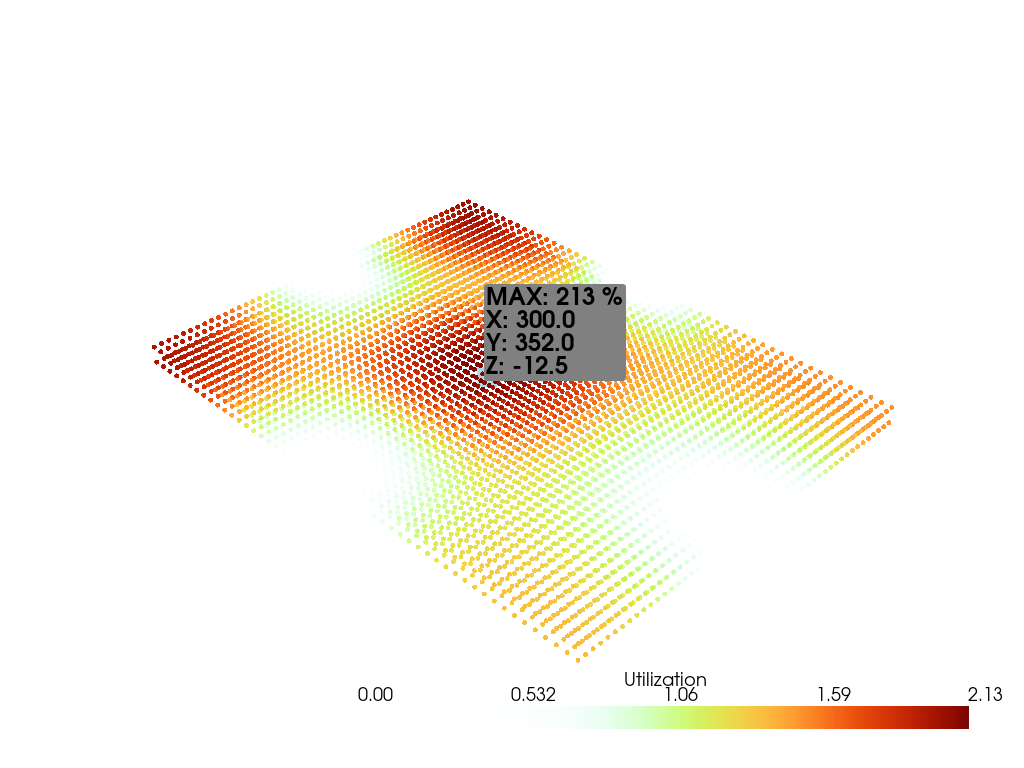

In [47]:
from sigmaepsilon.core.formatting import floatformatter

formatter = floatformatter(sig=3)

plotter = pv.Plotter(notebook=True)

scalars = util
points = util_coords
max_index = np.argmax(scalars)

p_max = point_cloud.points[max_index]
label_coords = np.array([p_max])

labels = [
    (
        f"MAX: {formatter.format(util.max()*100)} %"
        f"\nX: {points[max_index, 0]}"
        f"\nY: {points[max_index, 1]}"
        f"\nZ: {points[max_index, 2]}"
    ),
]

plotter.add_mesh(
    point_cloud,
    scalars="scalars",
    cmap="turbo",
    lighting=False,
    scalar_bar_args={"title": "Utilization"},
    render_points_as_spheres=True,
    opacity="sigmoid",
)

plotter.add_point_labels(
    label_coords, labels, point_size=20, font_size=24, always_visible=True
)

plotter.show(jupyter_backend="static")